In [38]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
import matplotlib.pyplot as plt

In [4]:

data = pd.read_excel(
    r"TCGA卵巢癌HRD分组生存数据.xlsx",
    engine='openpyxl'  
)

In [50]:
data.head()

,SampleID,HRDStatus,PFS_EVENT,PFS,HRD_numeric
0,229031112F1D,Positive,0,30.266667,1
1,229031070F1D,Negative,0,35.400000,0
2,229031076F1D,Negative,0,35.933333,0
3,229031116F1D,Positive,0,31.066667,1
4,229031129F1D,Negative,0,24.933333,0


HRD Negative Median PFS: 17.07 months


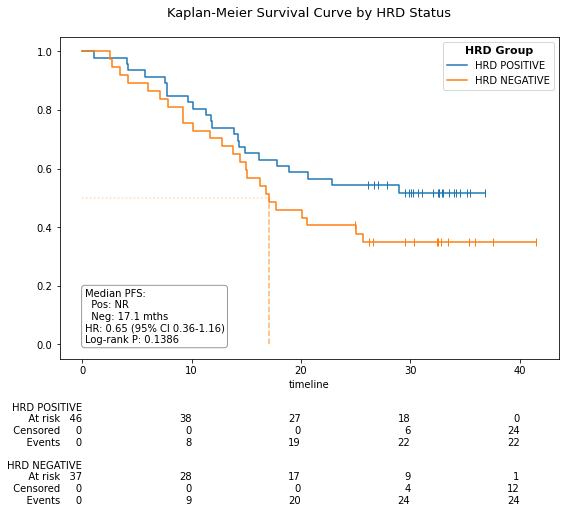

In [51]:

# --- 1. 计算统计量 (HR 和 P-value) --- # 增加部分
# 将 HRDStatus 转换为数值，以便 Cox 模型计算 HR
# 这里的逻辑是：Positive 相对于 Negative 的风险比
data['HRD_numeric'] = data['HRDStatus'].map({'Positive': 1, 'Negative': 0})

# 如果 summary 列名对不上，可以使用以下直接转换法：
# hr_lower = np.exp(cph.confidence_intervals_.iloc[0, 0])
# hr_upper = np.exp(cph.confidence_intervals_.iloc[0, 1])
# 计算 Hazard Ratio
cph = CoxPHFitter()
cph.fit(data[['PFS', 'PFS_EVENT', 'HRD_numeric']], duration_col='PFS', event_col='PFS_EVENT')
summary = cph.summary
hr = summary.loc['HRD_numeric', 'exp(coef)']

hr = cph.hazard_ratios_['HRD_numeric']
hr_lower = np.exp(cph.confidence_intervals_.iloc[0, 0])
hr_upper = np.exp(cph.confidence_intervals_.iloc[0, 1])
# 计算 Log-rank P-value
results = logrank_test(
    data[data['HRDStatus']=='Positive']['PFS'],
    data[data['HRDStatus']=='Negative']['PFS'],
    data[data['HRDStatus']=='Positive']['PFS_EVENT'],
    data[data['HRDStatus']=='Negative']['PFS_EVENT']
)
p_value = results.p_value

# --- 2. 绘图部分 ---
# 修改：稍微增加 figsize 的高度，给底部的风险表留空间
fig, ax = plt.subplots(figsize=(8, 7))
fitted_models = []
colors = ['#1f77b4', '#ff7f0e']

# 对每个 HRD 分组分别拟合并绘图
# reverse 让 Positive 在前
for i, group in enumerate(sorted(data['HRDStatus'].unique(), reverse=True)):
    kmf = KaplanMeierFitter()
    idx = data['HRDStatus'] == group
    durations = data.loc[idx, 'PFS']
    events = data.loc[idx, 'PFS_EVENT']
    
    label = f'HRD {group.upper()}'
    
    kmf.fit(durations=durations, event_observed=events, label=label)
    
    # 修改：censor_styles 内部改用 'ms'，修复之前的 TypeError
    kmf.plot_survival_function(
        ax=ax,
        show_censors=True,
        ci_show=False,
        censor_styles={'marker': '|', 'ms': 8} 
    )
    m_pfs = kmf.median_survival_time_
    if np.isfinite(m_pfs): # 确保中位生存期可计算（如果曲线没跌破0.5则为inf）
        # 画垂直于 X 轴的虚线
        ax.plot([m_pfs, m_pfs], [0, 0.5], color=colors[i], linestyle='--', alpha=0.6)
        # 画水平于 Y 轴的虚线
        ax.plot([0, m_pfs], [0.5, 0.5], color=colors[i], linestyle=':', alpha=0.3)
        print(f"HRD {group} Median PFS: {m_pfs:.2f} months")
    fitted_models.append(kmf)
    
# 定义一个格式化函数, 处理 NR 情况   
def format_median(m):
    return f"{m:.1f} mths" if np.isfinite(m) else "NR"
# --- 3. 添加统计信息标注 --- 
# 获取 mPFS 数值
m_pfs_pos = fitted_models[0].median_survival_time_
m_pfs_neg = fitted_models[1].median_survival_time_

# 格式化多行文本
stats_text = (f"Median PFS:\n"
              f"  Pos: {format_median(m_pfs_pos)}\n"
              f"  Neg: {format_median(m_pfs_neg)}\n"
              f"HR: {hr:.2f} (95% CI {hr_lower:.2f}-{hr_upper:.2f})\n"
              f"Log-rank P: {p_value:.4f}")
# 重新尝试绘制
ax.text(0.05, 0.05, stats_text, transform=ax.transAxes, fontsize=10, 
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round'))
# 6. 添加风险表
add_at_risk_counts(*fitted_models, ax=ax)

# 7. 设置坐标轴标签和图例
plt.ylabel("PFS Probability", fontsize=12)   # 修改：更专业的表述
plt.title("Kaplan-Meier Survival Curve by HRD Status", fontsize=13, pad=20)

# 自定义图例
legend = ax.legend(title="HRD Group", title_fontsize=11, fontsize=10)
legend.get_title().set_weight('bold')

# 8. 调整布局
plt.tight_layout()
# 修改：subplots_adjust 放在 tight_layout 之后，防止 risk table 截断
plt.subplots_adjust(bottom=0.28) 
plt.savefig(
"KM_Survival_Curve_HRD.png", dpi=300, bbox_inches='tight'
)
# 9. 显示图像
plt.show()

<Figure size 432x288 with 0 Axes>